# Notebook 01 - Indices

*Martin Vonk - 2022*

This notebooks shows an example calculation of the three drought indices:
- SPI: Standardized Precipitation Index
- SPEI: Standardized Precipitation Evaporation Index
- SGI: Standardized Groundwater Index

## Required packages

In [1]:
import spei as si  # si for standardized index
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt

print(si.show_versions())

Versions
python: 3.10.12
spei: 0.4.1
numpy: 1.26.4
scipy: 1.12.0
matplotlib: 3.8.3
pandas: 2.2.1



## Load time series

We use time series of the precipitation and potential (Makkink) evaporation from the Netherlands and obtain them from the python package [Pastas](https://github.com/pastas/pastas).

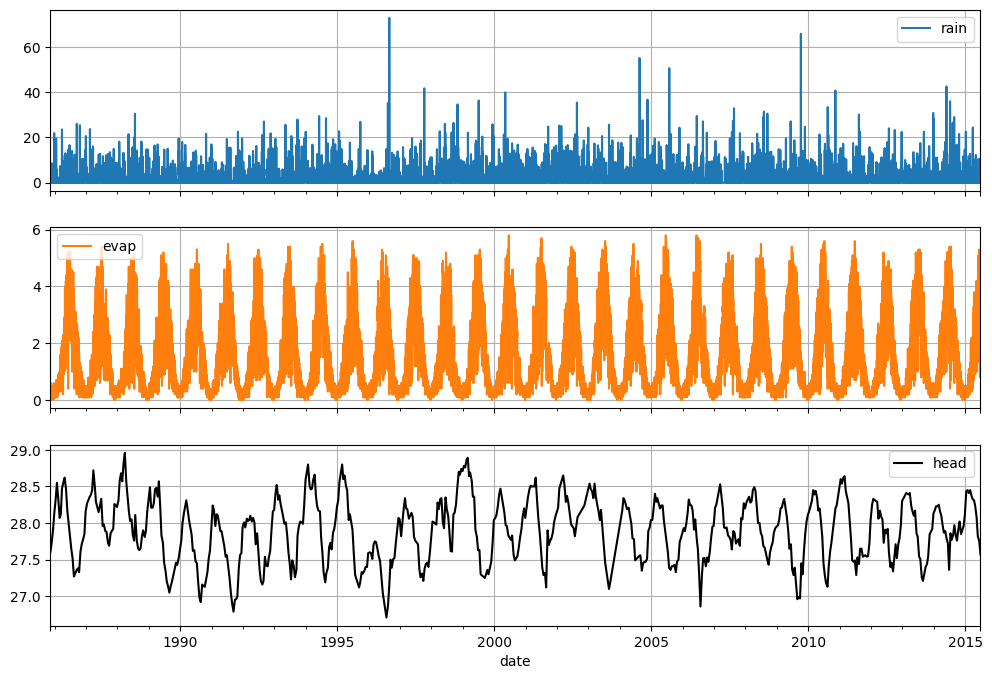

In [2]:
fileurl = "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data"
prec = (
    pd.read_csv(f"{fileurl}/rain_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
evap = (
    pd.read_csv(f"{fileurl}/evap_nb1.csv", index_col=0, parse_dates=True)
    .squeeze()
    .multiply(1e3)
)  # to mm
head = pd.read_csv(f"{fileurl}/head_nb1.csv", index_col=0, parse_dates=True).squeeze()

fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
prec.plot(ax=ax[0], legend=True, grid=True)
evap.plot(ax=ax[1], color="C1", legend=True, grid=True)
head.plot(ax=ax[2], color="k", legend=True, grid=True);

## Calculate SPI

The standardized precipitation index (SPI) is calculated using the gamma distribution from the [scipy stats library](https://docs.scipy.org/doc/scipy/reference/stats.html). In fact any continuous distribution of this library can be chosen. However there are sensible choices for the SPI such as gamma, lognorm (lognormal), fisk (log-logistic) or pearson3 distribution. The precipitation time series is summed over a 90D rolling interval, which corresponds to SPI3. 

For the literature we refer to: LLoyd-Hughes, B. and Saunders, M.A.: [A drought climatology for Europe](https://doi.org/10.1002/joc.846), 2002.

In [3]:
f = 90  # days
series = prec.rolling(f, min_periods=f).sum().dropna()
series

date
1980-03-30    219.0
1980-03-31    215.7
1980-04-01    226.7
1980-04-02    238.4
1980-04-03    232.4
              ...  
2016-10-27    129.3
2016-10-28    129.3
2016-10-29    129.6
2016-10-30    129.6
2016-10-31    123.1
Name: rain, Length: 13365, dtype: float64

In [4]:
spi3_gamma = si.spi(series, dist=scs.gamma, fit_freq="ME")
spi3_gamma

date
1980-03-30    0.650108
1980-03-31    0.594326
1980-04-01    1.166331
1980-04-02    1.354907
1980-04-03    1.258713
                ...   
2016-10-27   -1.237293
2016-10-28   -1.237293
2016-10-29   -1.231918
2016-10-30   -1.231918
2016-10-31   -1.348580
Length: 13365, dtype: float64

Lets try that with the pearson3 distribution:

In [5]:
spi3_pearson = si.spi(series, dist=scs.pearson3, fit_freq="ME")
spi3_pearson

date
1980-03-30    0.650108
1980-03-31    0.594326
1980-04-01    1.166332
1980-04-02    1.354908
1980-04-03    1.258713
                ...   
2016-10-27   -1.254106
2016-10-28   -1.254106
2016-10-29   -1.248306
2016-10-30   -1.248306
2016-10-31   -1.374687
Length: 13365, dtype: float64

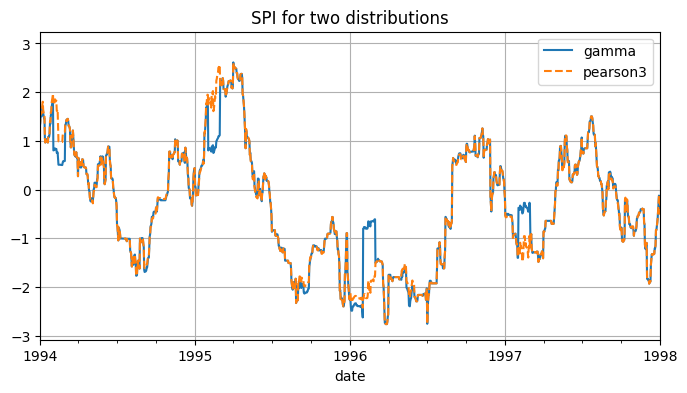

In [6]:
tmin, tmax = pd.to_datetime(["1994", "1998"])
plt.figure(figsize=(8, 4))
spi3_gamma.plot(label="gamma")
spi3_pearson.plot(label="pearson3", linestyle="--")
plt.xlim(tmin, tmax)
plt.legend()
plt.grid()
plt.title("SPI for two distributions");

As can be seen from the figure the distributions do not give significantly different output. This might not be the case for other time series of the precipitation. Example notebook 2 (example2_distribution.ipynb) provides more insight in how to choose the right distribution.

## Calculate SPEI

The standardized precipitation evaporation index (SPEI) is calculated by first substracting the evaporation from the precipitation time series. By default the fisk distribution is used to calculate the SPEI, however for other regularly used distributions are lognorm, pearson3 and genextreme. The code internally can also calculate the timescale (30D; SPEI1 in this case)

For the literature we refer to: Vicente-Serrano S.M., Beguería S., López-Moreno J.I.: [A Multi-scalar drought index sensitive to global warming: The Standardized Precipitation Evapotranspiration Index](https://doi.org/10.1175/2009JCLI2909.1), 2010.

In [7]:
pe = (prec - evap).dropna()  # calculate precipitation excess
spei1 = si.spei(pe, timescale=30, fit_freq="ME")
spei1

date
1980-01-30   -1.025023
1980-01-31   -0.896930
1980-02-01    0.115759
1980-02-02    0.142065
1980-02-03    0.323228
                ...   
2016-10-27   -0.271683
2016-10-28   -0.212795
2016-10-29   -0.171635
2016-10-30   -0.223138
2016-10-31   -0.250823
Length: 13425, dtype: float64

## Calculate SGI

The standardized groundwater index (SGI) is calculated using the method as described by [Bloomfield, J. P. and Marchant, B. P.: Analysis of groundwater drought building on the standardised precipitation index approach](https://doi.org/10.5194/hess-17-4769-2013), 2013. The way the SGI is calculated is the same as in the groundwater time series analysis package Pastas. A nice example notebook on computing the SGI with Pastas time series models can be found [here](https://pastas.readthedocs.io/en/latest/examples/011_sgi_example.ipynb.html).

For the head time series no distribution has to be selected by default. Since the time series has a 14 day frequency it is not resampled.

<Axes: xlabel='date'>

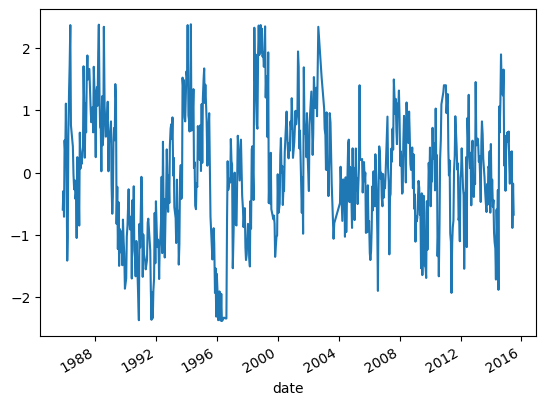

In [8]:
sgi = si.sgi(head, fit_freq="ME")
sgi.plot()

## Visualize indices

The indices should be interpreted as such:

| Range of Values   | Regime            | Probability [%] |
|-------------------|-------------------|-----------------|
| 2 < SI <= MAX     | Extremely Wet     | 2.3             |
| 1.5 < SI <= 2.0   | Very Wet          | 4.4             |
| 1.0 < SI <=1.5    | Moderately Wet    | 9.2             |
| -1.0 < SI <= 1.0  | Normal Conditions | 68.2            |
| -1.5 < SI <= -1.0 | Moderately Dry    | 9.2             |
| -2.0 < SI <= -1.5 | Very Dry          | 4.4             |
| MIN <= SI <= -2.0 | Extremely Dry     | 2.3             |

The time series for the standardized indices are plotted using a build in method:

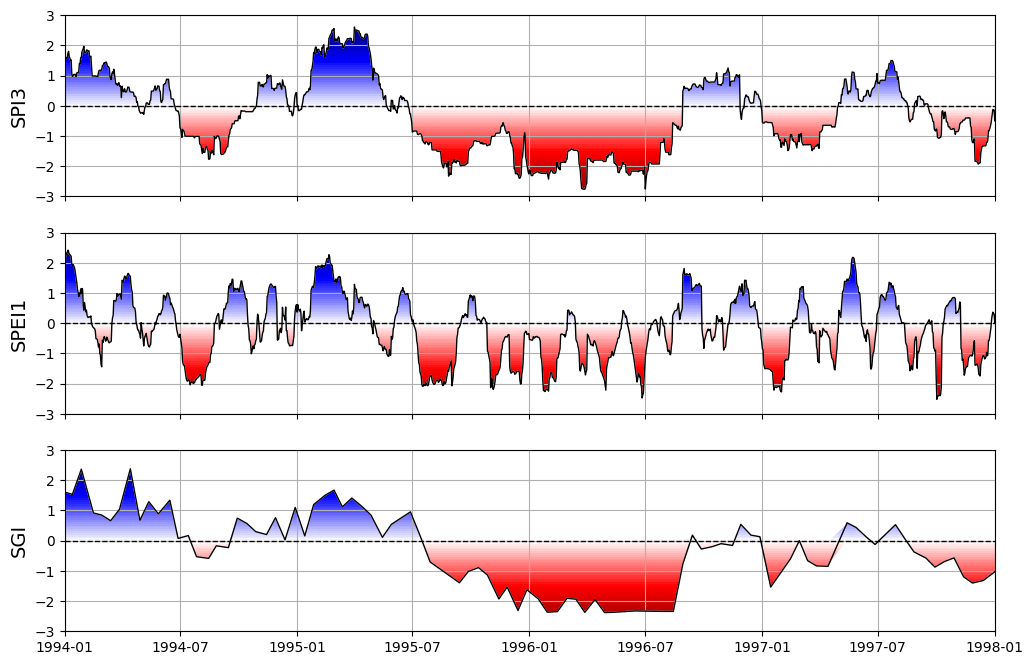

In [9]:
f, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
si.plot.si(spi3_pearson, ax=ax[0])
si.plot.si(spei1, ax=ax[1])
si.plot.si(sgi, ax=ax[2])
ax[0].set_xlim(pd.to_datetime(["1994", "1998"]))
[x.grid() for x in ax]
[ax[i].set_ylabel(n, fontsize=14) for i, n in enumerate(["SPI3", "SPEI1", "SGI"])];